# Analysis of PageRank Algorithm on PPI network
I created a PPI network using the interactions from ConsensusPathDB and I joined it with gene expression data (dual RNA-seq) obtained for the legionella infection setting.

In the dual RNA-seq, we have the following groups:
* *Control* (not treated)
* *GFP+* (cells with legionella infection)
* *GFP-* (cells without legionella)
* *PAM3* (inflammatory substance treatment. Should produce results similar to GFP+)

The gene expression for ~40.000 genes was preprocessing in the following way:
* Kick out genes whose average gene expression was higher than $10 \times$ the standard deviation
* Kick out genes with only less than 50% of the gene expressions being different from 0
* Scaled using a standard scaler

The network was then constructed for those genes only. That is, an edge is drawn between two genes only if both of them are in the list of genes for which we have gene expression and if the confidence of the interactions exceed $0.5$.

After network construction, isolated genes (no edges for gene) got kicked out as well. I am afterwards left with a network of 4862 genes.

On this network I applied the well-known PageRank algorithm. This resulted in a score for each gene and a higher score means that the gene is more important in the network.

**The goal of this notebook is to evaluate the results from PageRank, look into correlations with gene expression/differential expression, pathways and finally visualize the important genes in the network.**

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

## Load PageRank scores & Indices
This loads the gene expression data as well as the raw network from our hdf5 container.

In [57]:
# load gene expression values and network
fname = '../data/preprocessing/ppi_networks.h5'
with h5py.File(fname, 'r') as f:
    gene_expression_data = pd.DataFrame(f['gene_expression'][:])
    ppi_network = f['consensusPathDB_ppi'][:]
    gene_names = f['gene_names'][:]

# load pagerank scores and ranks
pagerank_scores = pd.DataFrame.from_csv('../data/pagerank/pagerank_scores.txt',
                                        encoding='utf-8',
                                        sep='\t',
                                        index_col=0
                                       )

In [58]:
print (pagerank_scores.shape, ppi_network.shape)

(4862, 3) (4862, 4862)


## Correlations between PageRank & Gene Expression Variance
Let's check the correlations between the PageRank and the variance of the gene expression. Trivially, one would expect that the high variance genes would be more prominent in the network.

However, there are a couple of factors that introduce noise here:
* The variance is calculated over 3 replicates of GFP+, GFP-, Control and PAM3. A couple of these groups are not expected to change during the time course of the infection so looking at the variance doesn't nessessarily make sense.
* There is experimental bias in here as well. Sometimes the replicates have very high variance, even though the gene is not at all differentially expressed.

In [59]:
# get the IDs from file and set them as index axis for the expression
expr_with_names = gene_expression_data.set_index(gene_names[:, 0]) #they have the same ordering

# set gene expression variance, mean and median and add to dataframe
expr_var = pd.DataFrame(expr_with_names.var(axis=1))
expr_var.columns = ['Gene_Expression_Variance']
expr_mean = pd.DataFrame(expr_with_names.mean(axis=1))
expr_mean.columns = ['Gene_Expression_Mean']
expr_median = pd.DataFrame(expr_with_names.median(axis=1))
expr_median.columns = ['Gene_Expression_Median']
pagerank_with_ge = pagerank_scores.join([expr_var, expr_mean, expr_median])

# write that to file
pagerank_with_ge.to_csv('../pagerank/pagerank_scores_with_ge.txt', sep='\t')

In [60]:
# compute correlation between gene expression and pagerank
#sorted_gene_expression = pagerank_with_ge.sort_values(by='Gene_Expression_Median', ascending=False)
print ("Correlation between PageRank & GE Mean: {}". \
       format(pagerank_with_ge.Gene_Expression_Mean.corr(pagerank_with_ge.PageRank_Score)))
print ("Correlation between PageRank & GE Variance: {}". \
       format(pagerank_with_ge.Gene_Expression_Variance.corr(pagerank_with_ge.PageRank_Score)))
print ("Correlation between PageRank & GE Median: {}". \
       format(pagerank_with_ge.Gene_Expression_Median.corr(pagerank_with_ge.PageRank_Score)))

Correlation between PageRank & GE Mean: 0.2360149447405269
Correlation between PageRank & GE Variance: 0.20305139680097462
Correlation between PageRank & GE Median: 0.2268122548392066


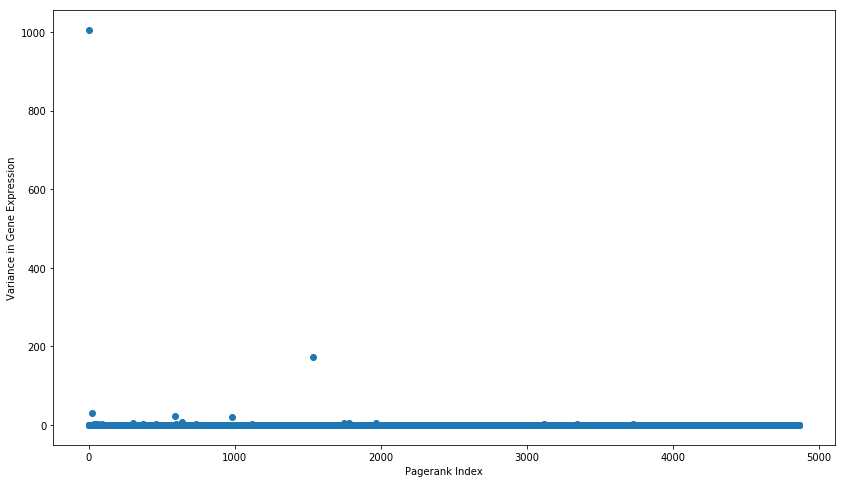

In [61]:
fig = plt.figure(figsize=(14, 8))
ax = plt.scatter(pagerank_with_ge.Rank, pagerank_with_ge.Gene_Expression_Variance)
#plt.xlim([0, 0.004])
t = plt.xlabel('Pagerank Index')
t = plt.ylabel('Variance in Gene Expression')

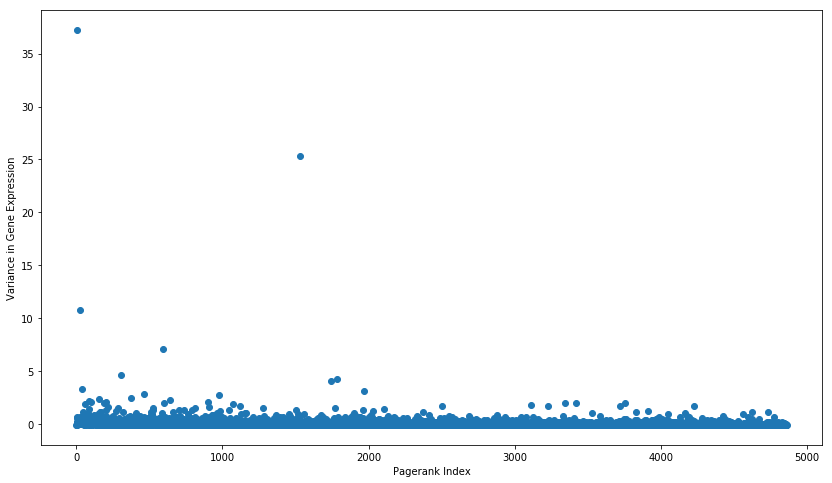

In [62]:
fig = plt.figure(figsize=(14, 8))
ax = plt.scatter(pagerank_with_ge.Rank, pagerank_with_ge.Gene_Expression_Mean)
#plt.xlim([0, 0.004])
t = plt.xlabel('Pagerank Index')
t = plt.ylabel('Variance in Gene Expression')

## Correlations between PageRank & Differential Expression
Because of the flaws of using only the variance, let's try having a look at the differentially expressed genes.
This should overcome the issues and maybe reveal some correlation between PageRank and DE.

Unfortunately, we only have GE data for the differentially expressed genes, while for all others, the p-values are $<0.05$

In [63]:
# load DE for GFP+ after 8 hours. Unfortunately, we only get DE for pval < .05
differential_expression = pd.DataFrame.from_csv('../data/differential_expression/GFPplusT8vsControlT805.tsv',
                                                sep='\t',
                                                index_col=2
                                               )
# remove gene name (already there)
differential_expression.drop('Gene-name', axis=1, inplace=True)
differential_expression.shape

(1016, 7)

In [64]:
pagerank_ge_and_de = pagerank_with_ge.join(differential_expression)

# compute correlation between differential expression and pagerank
print ("Correlation between PageRank & DE pvalue: {}". \
       format(pagerank_ge_and_de.pvalue.corr(pagerank_ge_and_de.PageRank_Score)))
print ("Correlation between PageRank & DE log2FoldChange: {}". \
       format(pagerank_ge_and_de.log2FoldChange.corr(pagerank_with_ge.PageRank_Score)))
print ("Correlation between PageRank & GE baseMean: {}". \
       format(pagerank_ge_and_de.baseMean.corr(pagerank_with_ge.PageRank_Score)))

Correlation between PageRank & DE pvalue: -0.003988536785308605
Correlation between PageRank & DE log2FoldChange: 0.006537348528490422
Correlation between PageRank & GE baseMean: 0.11620311558924651


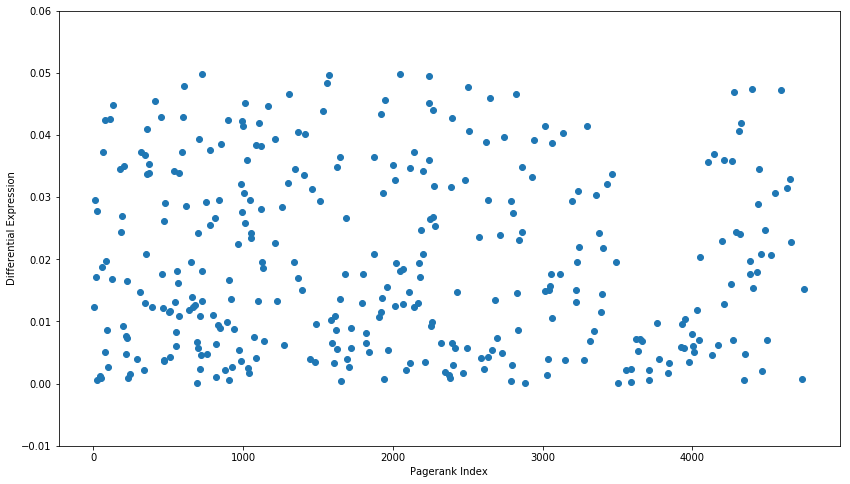

In [65]:
fig = plt.figure(figsize=(14, 8))
ax = plt.scatter(pagerank_ge_and_de.Rank, pagerank_ge_and_de.pvalue)
#plt.xlim([0, 0.004])
t = plt.xlabel('Pagerank Index')
t = plt.ylabel('Differential Expression')

## Correlations between PageRank & Gene Expression PCA Loadings
When the variance/mean of the gene expression doesn't correlate with the PageRank, let's try something different.
I want to see if there is a correlation between the PCA loadings from the 20% most varying  genes and the PageRank.

In [67]:
loadings_pc1 = pd.DataFrame.from_csv('../data/preprocessing/loadings_comp_1.tsv',
                                     sep='\t'
                                    )
loadings_pc1 = loadings_pc1.drop(['Abs_Loadings', 'Gene_Name'], axis=1)

loadings_pc2 = pd.DataFrame.from_csv('../data/preprocessing/loadings_comp_2.tsv',
                                     sep='\t'
                                    )
loadings_pc2 = loadings_pc2.drop(['Abs_Loadings', 'Gene_Name'], axis=1)

loadings_pc3 = pd.DataFrame.from_csv('../data/preprocessing/loadings_comp_3.tsv',
                                     sep='\t'
                                    )
loadings_pc3 = loadings_pc3.drop(['Abs_Loadings', 'Gene_Name'], axis=1)

In [68]:
pagerank_de_ge_loadings = pagerank_ge_and_de
for comp in range(1, 4):
    loadings = pd.DataFrame.from_csv('../data/preprocessing/loadings_comp_{}.tsv'.format(comp),
                                         sep='\t'
                                        )
    loadings.drop('Abs_Loadings', axis=1, inplace=True)
    loadings.drop('Gene_Name', axis=1, inplace=True) # gene name is already there
    loadings.columns = ['Loadings_Comp{}'.format(comp)]
    pagerank_de_ge_loadings = pagerank_de_ge_loadings.join(loadings, how='left')
    print (pagerank_de_ge_loadings.shape)
pagerank_de_ge_loadings.head()

(4862, 14)
(4862, 15)
(4862, 16)


,Gene_Name,Rank,PageRank_Score,Gene_Expression_Variance,Gene_Expression_Mean,Gene_Expression_Median,Gene-type,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Loadings_Comp1,Loadings_Comp2,Loadings_Comp3
Gene_ID,,,,,,,,,,,,,,,,
ENSG00000198400,NTRK1,1,0.006285,0.000842,-0.105612,-0.114468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000082898,XPO1,2,0.005032,0.094383,0.634362,0.731523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004233,-0.004978,-0.001615
ENSG00000150991,UBC,3,0.004158,1005.958932,37.256122,22.989679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.533175,-0.256197,0.005203
ENSG00000146648,EGFR,4,0.004000,0.000809,-0.098163,-0.105476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000177885,GRB2,5,0.003489,0.102209,0.594980,0.607916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001742,-0.006932,0.001507


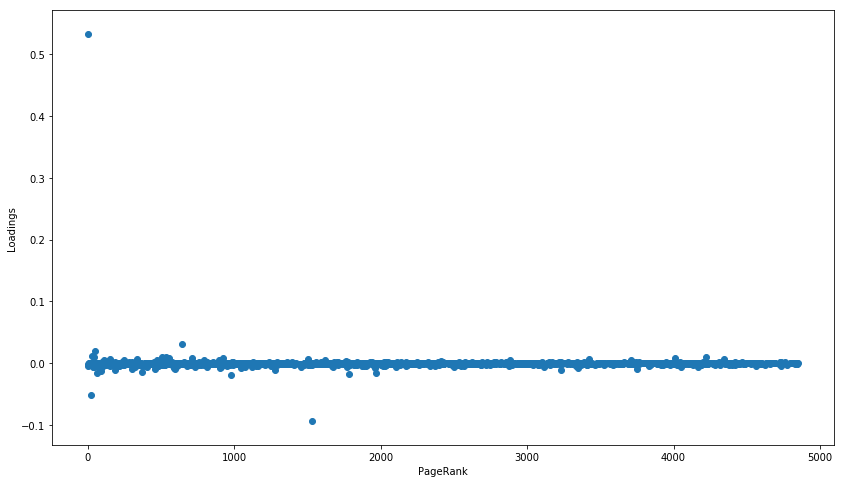

In [69]:
fig = plt.figure(figsize=(14, 8))
pc1_df = loadings_pc1.join(pagerank_ge_and_de)
pc1_df.shape
plt.scatter(pc1_df.Rank, pc1_df.Loadings)
plt.xlabel('PageRank')
plt.ylabel('Loadings')

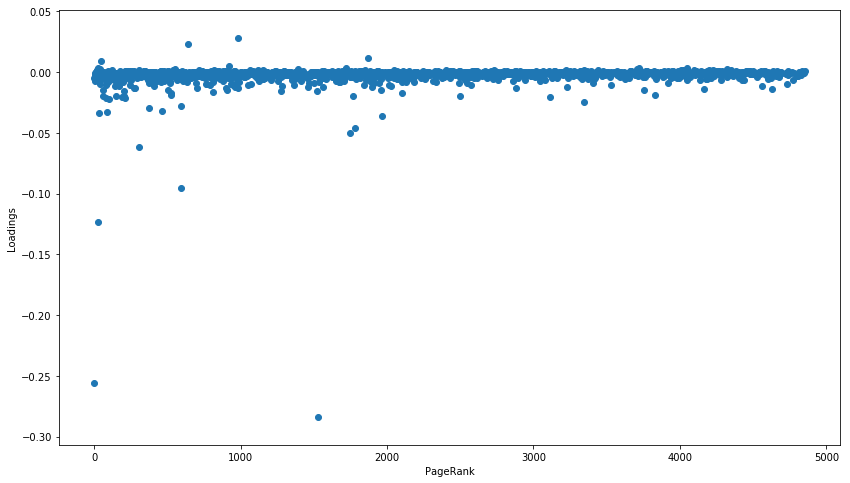

In [70]:
fig = plt.figure(figsize=(14, 8))
pc2_df = loadings_pc2.join(pagerank_ge_and_de)
plt.scatter(pc2_df.Rank, pc2_df.Loadings)
plt.xlabel('PageRank')
plt.ylabel('Loadings')

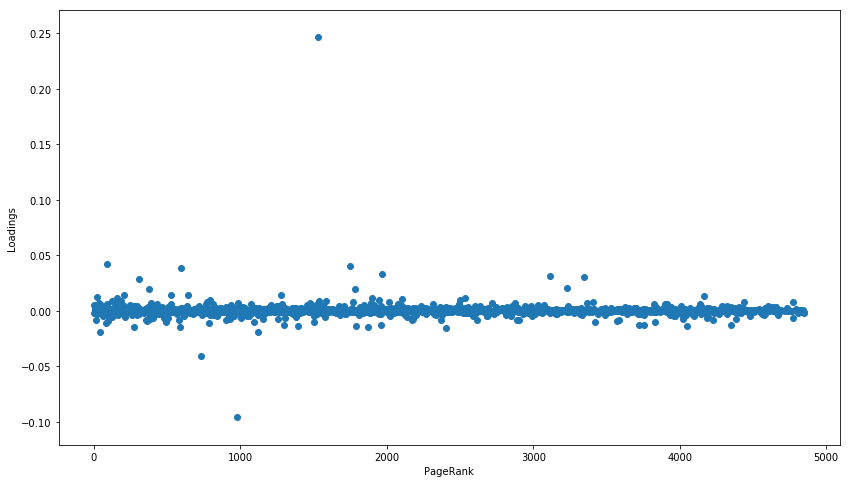

In [71]:
fig = plt.figure(figsize=(14, 8))
pc3_df = loadings_pc3.join(pagerank_ge_and_de)
plt.scatter(pc3_df.Rank, pc3_df.Loadings)
plt.xlabel('PageRank')
plt.ylabel('Loadings')

## Correlations of PageRank and Network Properties
Next, I'd like to do a sanity check. The PageRank should somehow correlate with basic network properties, such as:
* Node Degree
* Betweenness
* etc.

In [72]:
import networkx as nx

In [73]:
G = nx.from_numpy_matrix(A=ppi_network)
node_degree = nx.degree(G)
degree_np = np.zeros(len(node_degree))
for key, val in node_degree.items():
    degree_np[key] = val

In [74]:
print ("Mean Node Degree in PPI Network: {}".format(degree_np.mean()))

Mean Node Degree in PPI Network: 17.944055944055943


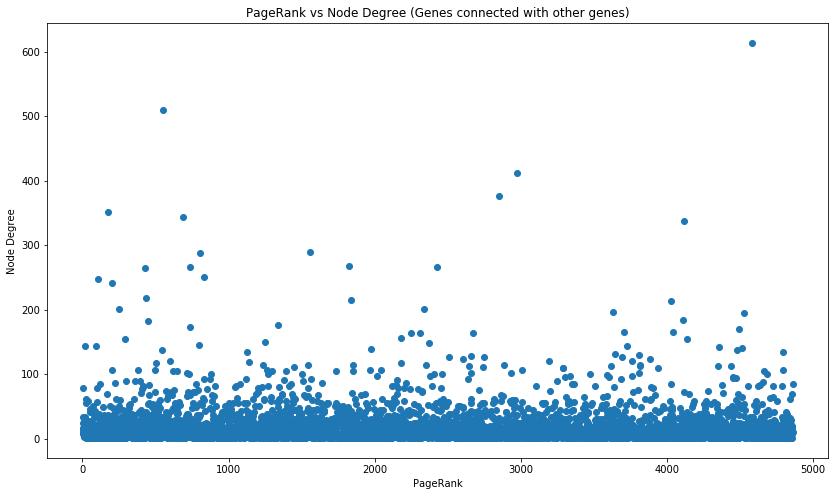

In [75]:
fig = plt.figure(figsize=(14, 8))
plt.scatter(pagerank_ge_and_de.Rank, degree_np)
plt.title('PageRank vs Node Degree (Genes connected with other genes)')
plt.xlabel('PageRank')
plt.ylabel('Node Degree')

In [76]:
# centrality now (takes time)
betweenness_centrality = nx.betweenness_centrality(G)

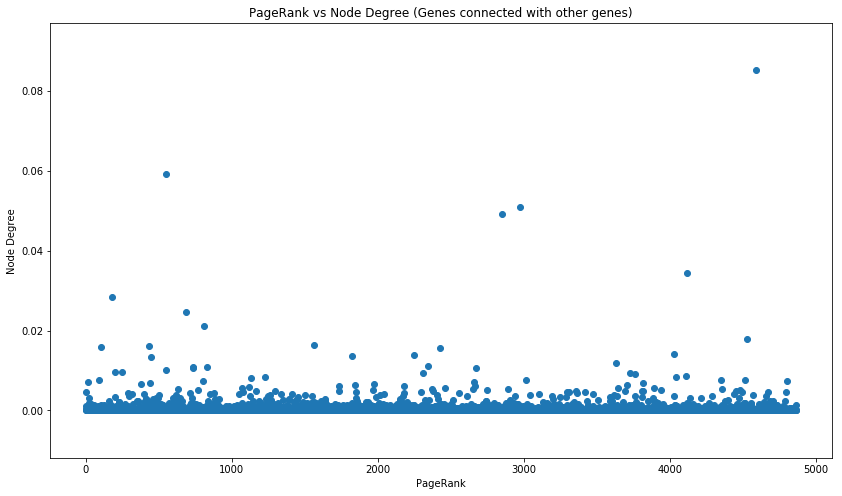

In [108]:
betweenness_np = np.zeros(len(node_degree))
for key, val in betweenness_centrality.items():
    betweenness_np[key] = val

fig = plt.figure(figsize=(14, 8))
plt.scatter(pagerank_with_ge_varmean.Rank, betweenness_np)
plt.title('PageRank vs Node Degree (Genes connected with other genes)')
plt.xlabel('PageRank')
plt.ylabel('Node Degree')

### Fuse Dataframe with gene expression, differential expression, loadings and network properties

In [55]:
network_props = pd.DataFrame(np.vstack([degree_np, betweenness_np]).T)
network_props.columns = ['Node_Degree', 'Node_Betweenness']
network_props = network_props.set_index(gene_names[:, 0])
pagerank_whole_props = pagerank_de_ge_loadings.join(network_props)

NameError: name 'betweenness_np' is not defined

In [223]:
# compute correlation between gene expression and pagerank
print ("Correlation between PageRank & Node Degree: {}". \
       format(pagerank_whole_props.Node_Degree.corr(pagerank_whole_props.PageRank_Score)))
print ("Correlation between PageRank & Node Betweenness: {}". \
       format(pagerank_whole_props.Node_Betweenness.corr(pagerank_whole_props.PageRank_Score)))

Correlation between PageRank & Node Degree: 0.9875784200087704
Correlation between PageRank & Node Betweenness: 0.8620914212811688


## Write Whole Dataframe to Disk

In [221]:
pagerank_whole_props.to_csv('../data/pagerank/network_properties.tsv', sep='\t')

## Do Wigos genes pop up in my top candidates?
I found some high correlation between network properties, differential expression and gene expression with the results from PageRank.

Next, I want to know if any of the high ranked genes also pop up in the list that I got from Wigo.

In [34]:
infection_genes = pd.DataFrame.from_csv('../data/labels/labels_wigo.csv', sep='\t', index_col=3)
infection_genes

,Unnamed: 0,Gene-type,Gene-name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Unnamed: 10
Ensembl,,,,,,,,,,
ENSG00000225206,3.0,lincRNA,MIR137HG,52.633304,3.960701,0.463280,8.549260,1.240000e-17,1.280000e-15,8h
ENSG00000228065,172.0,lincRNA,LINC01515,39.461913,-2.723455,0.478758,-5.688578,1.280000e-08,2.780000e-07,NaN
ENSG00000259820,27.0,lincRNA,AC083843.1,81.103451,2.265429,0.353440,6.409661,1.460000e-10,4.490000e-09,NaN
ENSG00000280721,17.0,lincRNA,AC133644.2,60.786125,3.019979,0.381553,7.914972,2.470000e-15,2.270000e-13,16h
ENSG00000235244,177.0,lincRNA,RP11-761E20.1,28.341391,-2.127854,0.467060,-4.555848,5.220000e-06,7.380000e-05,NaN
ENSG00000266411,9.0,lincRNA,RP11-180P8.3,19.185870,3.627501,0.569187,6.373122,1.850000e-10,7.370000e-09,NaN
ENSG00000144381,101.0,protein_coding,HSPD1,6096.255665,4.162276,0.303424,13.717679,7.960000e-43,1.270000e-39,8h
ENSG00000149257,47.0,protein_coding,SERPINH1,3240.130038,4.779545,0.296223,16.134950,1.450000e-58,8.660000e-55,NaN
ENSG00000086061,161.0,protein_coding,DNAJA1,2578.233778,3.633003,0.292479,12.421422,2.000000e-35,1.370000e-32,NaN


In [40]:
for index, row in pagerank_scores[:100].iterrows():
    if index in infection_genes:
        print ("Found Gene with Rank {} and ID {} ({}) in Wigos list of infection genes"\
               .format(row['Rank'], index, row['Gene_Name'])
              )

In [54]:
for index, row in infection_genes.iterrows():
    if index in pagerank_scores.index:
        print ('Found Ensembl ID {} ({})\tPageRank: {}'\
               .format(index, row['Gene-name'], pagerank_scores.loc[index]['Rank'])
              )

Found Ensembl ID ENSG00000013441 (CLK1)	PageRank: 555
Found Ensembl ID ENSG00000168439 (STIP1)	PageRank: 339
Found Ensembl ID ENSG00000114416 (FXR1)	PageRank: 475
Found Ensembl ID ENSG00000004478 (FKBP4)	PageRank: 715
